In [1]:
pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
# Cell 1: 导入依赖和环境设置
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
# 添加AMP混合精度训练支持
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.patches as patches
from tqdm.auto import tqdm
import warnings
import time
from PIL import Image
import gc
warnings.filterwarnings('ignore')

# 解释工具导入
try:
    from captum.attr import LayerGradCam, IntegratedGradients
    from captum.attr import visualization as viz
    CAPTUM_AVAILABLE = True
except ImportError:
    print("⚠️ Captum not available. Install with: pip install captum")
    CAPTUM_AVAILABLE = False

# 设置matplotlib使用英文字体和高DPI
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

print("🚀 Kaggle Multi-Model Ensemble Deepfake Detection with AMP")
print(f"PyTorch Version: {torch.__version__}")
print(f"Captum Available: {CAPTUM_AVAILABLE}")
print(f"AMP Available: {torch.cuda.is_available() and hasattr(torch.cuda.amp, 'autocast')}")

🚀 Kaggle Multi-Model Ensemble Deepfake Detection with AMP
PyTorch Version: 2.6.0+cu124
Captum Available: True
AMP Available: True


In [3]:
# Cell 2: 参数配置
BASE_PATH = '/kaggle/input/deepfake-and-real-images/Dataset'
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
VAL_PATH = os.path.join(BASE_PATH, 'Validation')

# 训练参数
# 图像大小
IMG_SIZE = 256

# 批次大小
BATCH_SIZE = 96
VAL_BATCH_SIZE = 96

# 学习率
LEARNING_RATE = 1e-4

# 训练轮数
EPOCHS = 15

# 权重衰减系数
WEIGHT_DECAY = 1e-4

# 早停轮数
PATIENCE = 4

# 数据加载器的工作进程数量
NUM_WORKERS = 8

# AMP混合精度训练开关
USE_AMP = True  # 启用混合精度训练

# 获取当前设备的GPU信息
NUM_GPUS = torch.cuda.device_count()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

# AMP支持检查
if torch.cuda.is_available() and USE_AMP:
    print("✅ AMP (Automatic Mixed Precision) enabled")
    print("📈 Expected benefits: ~30% faster training, ~40% memory reduction")
elif not torch.cuda.is_available():
    USE_AMP = False
    print("⚠️ CUDA not available, AMP disabled")
else:
    print("ℹ️ AMP disabled by configuration")

if torch.cuda.is_available():
    if NUM_GPUS > 1:
        print(f"Multi-GPU Training: {[torch.cuda.get_device_name(i) for i in range(NUM_GPUS)]}")
        print(f"GPU Count: {NUM_GPUS}")
    else:
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    for i in range(NUM_GPUS):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"GPU {i} Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f}GB")
else:
    NUM_WORKERS = 0
    print("Using CPU Training")

# 创建输出目录
PLOTS_DIR = './works/plots'
MODELS_DIR = './works/models'  # 新增：模型保存目录
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)  # 创建模型保存目录

Device: cuda
✅ AMP (Automatic Mixed Precision) enabled
📈 Expected benefits: ~30% faster training, ~40% memory reduction
Multi-GPU Training: ['Tesla T4', 'Tesla T4']
GPU Count: 2
GPU 0: Tesla T4
GPU 0 Memory: 14.7GB
GPU 1: Tesla T4
GPU 1 Memory: 14.7GB


In [4]:
# Cell 3: 数据加载函数
classes = ['Real', 'Fake']

def create_dataframe(data_path, dataset_type):
    """创建数据集DataFrame"""
    filepaths, labels = [], []
    
    for label_idx, cls in enumerate(classes):
        folder = os.path.join(data_path, cls)
        if os.path.exists(folder):
            for img_name in os.listdir(folder):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    filepaths.append(os.path.join(folder, img_name))
                    labels.append(label_idx)
    
    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    print(f"{dataset_type}集图片数: {len(df)}")
    if len(df) > 0:
        print(f"{dataset_type}集类别分布:")
        for idx, cls in enumerate(classes):
            count = len(df[df['label'] == idx])
            print(f"  {cls}: {count} ({count/len(df)*100:.1f}%)")
    return df

In [5]:
# Cell 4: 数据预处理和增强
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # 增加旋转角度
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 添加平移变换
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 数据增强可视化函数
def visualize_data_augmentation(train_df, save_dir='./works/plots'):
    """Visualize multiple data augmentation effects on the same random image"""
    import random
    os.makedirs(save_dir, exist_ok=True)
    
    # 随机选择一张图片
    random_idx = random.randint(0, len(train_df) - 1)
    sample_image_path = train_df.iloc[random_idx]['filepath']
    sample_label = train_df.iloc[random_idx]['label']
    label_name = classes[sample_label]
    
    print(f"🎲 Randomly selected image: {os.path.basename(sample_image_path)} (Label: {label_name})")
    
    # 读取原始图像
    original_img = cv2.imread(sample_image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # 定义各种数据增强变换（基于train_transform的组件）- 改为英文
    augmentations = {
        'Original Image': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE, IMG_SIZE))
        ]),
        'Horizontal Flip': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=1.0)
        ]),
        'Rotation 15°': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomRotation(degrees=15)
        ]),
        'Color Jitter': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15)
        ]),
        'Affine Transform': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
        ]),
        'Full Training Aug': train_transform  # 使用完整的train_transform
    }
    
    # 创建子图
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Data Augmentation Comparison - {label_name} Image', fontsize=16, fontweight='bold')
    
    for idx, (aug_name, transform) in enumerate(augmentations.items()):
        row = idx // 3
        col = idx % 3
        
        # 应用变换
        if aug_name == 'Full Training Aug':
            # 对于完整的train_transform，需要反标准化显示
            augmented_tensor = transform(original_img)
            # 反标准化
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            denormalized = augmented_tensor * std + mean
            denormalized = torch.clamp(denormalized, 0, 1)
            augmented_img = denormalized.permute(1, 2, 0).numpy()
        else:
            augmented_img = transform(original_img)
        
        # 显示图像
        axes[row, col].imshow(augmented_img)
        axes[row, col].set_title(aug_name, fontsize=12, fontweight='bold')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'data_augmentation_comparison.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Data augmentation comparison saved to: {os.path.join(save_dir, 'data_augmentation_comparison.png')}")

# 自定义数据集类,用于加载和处理Deepfake图像数据
class DeepfakeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        label = self.df.iloc[idx]['label']
        return img, label



In [6]:
# Cell 5: 模型定义
def create_efficientnet_b0():
    """创建EfficientNet-B0模型"""
    model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    model.classifier[1] = nn.Linear(1280, 2)
    return model

def create_resnet18():
    """创建ResNet18模型"""
    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(512, 2)
    return model

def create_convnext_tiny():
    """创建ConvNeXt-Tiny模型"""
    model = models.convnext_tiny(weights='IMAGENET1K_V1')
    model.classifier[2] = nn.Linear(768, 2)
    return model

# 模型配置字典
MODEL_CONFIGS = {
    'efficientnet_b0': {
        'create_fn': create_efficientnet_b0,
        'name': 'EfficientNet-B0'
    },
    'resnet18': {
        'create_fn': create_resnet18,
        'name': 'ResNet18'
    },
    'convnext_tiny': {
        'create_fn': create_convnext_tiny,
        'name': 'ConvNeXt-Tiny'
    }
}


In [7]:
# Cell 6: 单模型训练函数
def train_single_model(model_key, train_loader, val_loader, save_path):
    """训练单个模型 - 支持AMP混合精度训练"""
    print(f"\n🔥 Starting Training {MODEL_CONFIGS[model_key]['name']}")
    if USE_AMP:
        print("⚡ Using AMP (Automatic Mixed Precision) for faster training")
    
    # 记录训练开始时间
    start_time = time.time()
    
    # 创建模型
    model = MODEL_CONFIGS[model_key]['create_fn']()
    model = model.to(DEVICE)
    
    # 多GPU支持
    if NUM_GPUS > 1:
        model = nn.DataParallel(model)
        print(f"✅ Model configured for multi-GPU training with {NUM_GPUS} GPUs")
    
    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # AMP梯度缩放器
    scaler = GradScaler() if USE_AMP else None
    
    # 训练记录
    best_val_acc = 0
    patience_counter = 0
    train_losses, val_losses, val_accuracies, learning_rates = [], [], [], []
    val_f1_scores = []
    
    for epoch in range(EPOCHS):
        # 训练阶段
        model.train()
        train_loss = 0
        
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
            imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            
            optimizer.zero_grad()
            
            # AMP前向传播
            if USE_AMP:
                with autocast():
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                
                # AMP反向传播
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # 标准训练
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
                imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
                
                # AMP验证
                if USE_AMP:
                    with autocast():
                        outputs = model(imgs)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # 显存监控
        if torch.cuda.is_available():
            current_memory = torch.cuda.memory_allocated() / 1024**3
            max_memory = torch.cuda.max_memory_allocated() / 1024**3
            memory_info = f"GPU Mem: {current_memory:.2f}GB/{max_memory:.2f}GB"
        else:
            memory_info = ""
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, LR: {current_lr:.6f} {memory_info}")
        
        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # 保存模型时处理多GPU情况
            if NUM_GPUS > 1:
                torch.save(model.module.state_dict(), save_path)
            else:
                torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved, validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("⛔ Early stopping triggered")
                break
        
        # 每个epoch后清理显存
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # 计算训练时间
    training_time = time.time() - start_time
    print(f"⏱️ Training completed in {training_time:.2f} seconds")
    
    # 最终显存清理
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print(f"🧹 最终 GPU 显存占用: {torch.cuda.memory_allocated()/1024**3:.2f}GB")
    
    return {
         'best_acc': best_val_acc,
         'train_losses': train_losses,
         'val_losses': val_losses,
         'val_accuracies': val_accuracies,
         'val_f1_scores': val_f1_scores,
         'learning_rates': learning_rates,
         'training_time': training_time,
         'amp_enabled': USE_AMP
     }

In [8]:
# Cell 7: 可视化函数
def plot_training_history(model_results, save_dir=PLOTS_DIR):
    """绘制训练历史可视化"""
    print("📊 Generating training history visualizations...")
    
    # 1. 单模型训练历史 (2x2 子图)
    for model_key, results in model_results.items():
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'{MODEL_CONFIGS[model_key]["name"]} Training History', fontsize=16, fontweight='bold')
        
        epochs = range(1, len(results['train_losses']) + 1)
        
        # Loss曲线
        axes[0, 0].plot(epochs, results['train_losses'], 'b-', label='Train Loss', linewidth=2)
        axes[0, 0].plot(epochs, results['val_losses'], 'r-', label='Validation Loss', linewidth=2)
        axes[0, 0].set_title('Training & Validation Loss', fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Accuracy曲线
        axes[0, 1].plot(epochs, results['val_accuracies'], 'g-', label='Validation Accuracy', linewidth=2)
        axes[0, 1].set_title('Validation Accuracy', fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Learning Rate曲线
        axes[1, 0].plot(epochs, results['learning_rates'], 'purple', linewidth=2)
        axes[1, 0].set_title('Learning Rate Schedule', fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Validation Accuracy分布
        axes[1, 1].hist(results['val_accuracies'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 1].axvline(results['best_acc'], color='red', linestyle='--', linewidth=2, label=f'Best: {results["best_acc"]:.4f}')
        axes[1, 1].set_title('Validation Accuracy Distribution', fontweight='bold')
        axes[1, 1].set_xlabel('Accuracy')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        save_path = os.path.join(save_dir, f'{model_key}_training_history.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✅ Saved: {save_path}")
    
    # 2. 多模型对比图 (四线对比)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Multi-Model Training Comparison', fontsize=16, fontweight='bold')
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # 验证Loss对比
    for i, (model_key, results) in enumerate(model_results.items()):
        epochs = range(1, len(results['val_losses']) + 1)
        axes[0, 0].plot(epochs, results['val_losses'], color=colors[i % len(colors)], 
                       label=MODEL_CONFIGS[model_key]['name'], linewidth=2)
    axes[0, 0].set_title('Validation Loss Comparison', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 验证Accuracy对比
    for i, (model_key, results) in enumerate(model_results.items()):
        epochs = range(1, len(results['val_accuracies']) + 1)
        axes[0, 1].plot(epochs, results['val_accuracies'], color=colors[i % len(colors)], 
                       label=MODEL_CONFIGS[model_key]['name'], linewidth=2)
    axes[0, 1].set_title('Validation Accuracy Comparison', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 训练时长对比
    model_names = [MODEL_CONFIGS[key]['name'] for key in model_results.keys()]
    training_times = [results['training_time'] for results in model_results.values()]
    bars = axes[1, 0].bar(model_names, training_times, color=colors[:len(model_names)], alpha=0.7)
    axes[1, 0].set_title('Training Time Comparison', fontweight='bold')
    axes[1, 0].set_ylabel('Training Time (seconds)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 添加数值标签
    for bar, time_val in zip(bars, training_times):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # F1-Score对比
    for i, (model_key, results) in enumerate(model_results.items()):
        epochs = range(1, len(results['val_f1_scores']) + 1)
        axes[1, 1].plot(epochs, results['val_f1_scores'], color=colors[i % len(colors)], 
                       label=MODEL_CONFIGS[model_key]['name'], linewidth=2)
    axes[1, 1].set_title('F1-Score Comparison', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, 'multi_model_comparison.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved: {save_path}")

def plot_confusion_matrix(y_true, y_pred, title, save_name, save_dir=PLOTS_DIR):
    """绘制混淆矩阵"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    
    # 添加准确率信息
    accuracy = accuracy_score(y_true, y_pred)
    plt.text(0.5, -0.1, f'Accuracy: {accuracy:.4f}', 
             transform=plt.gca().transAxes, ha='center', fontweight='bold')
    
    save_path = os.path.join(save_dir, f'{save_name}_confusion_matrix.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Saved: {save_path}")

def plot_ensemble_analysis(models_dict, data_loader, device):
    """绘制集成分析可视化 - 优化版本"""
    print("🔍 生成集成分析可视化...")
    
    # 收集所有模型的预测结果
    model_predictions = {}
    true_labels = []
    
    # 初始化模型预测字典
    for model_key in models_dict.keys():
        model_predictions[model_key] = []
    
    # 设置模型为评估模式
    for model in models_dict.values():
        model.eval()
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(tqdm(data_loader, desc="收集模型预测")):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            # 收集真实标签
            true_labels.extend(labels.cpu().numpy())
            
            # 收集每个模型的预测
            for model_key, model in models_dict.items():
                # AMP推理
                if USE_AMP:
                    with autocast():
                        outputs = model(imgs)
                else:
                    outputs = model(imgs)
                
                _, predicted = torch.max(outputs, 1)
                model_predictions[model_key].extend(predicted.cpu().numpy())
    
    # 转换为numpy数组
    for key in model_predictions:
        model_predictions[key] = np.array(model_predictions[key])
    true_labels = np.array(true_labels)
    
    # 验证数组长度一致性
    print(f"📊 数据验证: 真实标签数量={len(true_labels)}")
    for key, preds in model_predictions.items():
        print(f"📊 {MODEL_CONFIGS[key]['name']} 预测数量={len(preds)}")
        if len(preds) != len(true_labels):
            print(f"⚠️ 警告: {MODEL_CONFIGS[key]['name']} 预测数量与真实标签不匹配!")
            return None
    
    # 1. 模型预测一致性热图
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Ensemble Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 计算模型间一致性
    model_keys = list(model_predictions.keys())
    n_models = len(model_keys)
    consistency_matrix = np.zeros((n_models, n_models))
    
    for i, key1 in enumerate(model_keys):
        for j, key2 in enumerate(model_keys):
            if i == j:
                consistency_matrix[i, j] = 1.0
            else:
                agreement = np.mean(model_predictions[key1] == model_predictions[key2])
                consistency_matrix[i, j] = agreement
    
    # 绘制一致性热图
    model_names = [MODEL_CONFIGS[key]['name'] for key in model_keys]
    sns.heatmap(consistency_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r',
                xticklabels=model_names, yticklabels=model_names, ax=axes[0, 0])
    axes[0, 0].set_title('Model Prediction Consistency', fontweight='bold')
    
    # 2. 各模型准确率对比
    accuracies = []
    for key in model_keys:
        acc = accuracy_score(true_labels, model_predictions[key])
        accuracies.append(acc)
        print(f"📊 {MODEL_CONFIGS[key]['name']} 准确率: {acc:.4f}")
    
    bars = axes[0, 1].bar(model_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'][:len(model_names)])
    axes[0, 1].set_title('Individual Model Accuracy', fontweight='bold')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].set_ylim(0.8, 1.0)  # 设置y轴范围
    
    # 添加数值标签
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                       f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. 集成预测置信度分析
    print("🔍 计算集成预测置信度...")
    all_probs = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(data_loader, desc="计算置信度"):
            imgs = imgs.to(device, non_blocking=True)
            batch_probs = []
            
            for model_key, model in models_dict.items():
                if USE_AMP:
                    with autocast():
                        outputs = model(imgs)
                else:
                    outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)
                batch_probs.append(probs.cpu().numpy())
            
            # 平均概率
            ensemble_probs = np.mean(batch_probs, axis=0)
            all_probs.extend(ensemble_probs)
    
    all_probs = np.array(all_probs)
    ensemble_confidence = np.max(all_probs, axis=1)
    ensemble_predictions = np.argmax(all_probs, axis=1)
    
    # 正确vs错误预测的置信度分布
    correct_mask = ensemble_predictions == true_labels
    correct_confidence = ensemble_confidence[correct_mask]
    incorrect_confidence = ensemble_confidence[~correct_mask]
    
    axes[1, 0].hist(correct_confidence, bins=30, alpha=0.7, label='Correct', color='green', density=True)
    axes[1, 0].hist(incorrect_confidence, bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
    axes[1, 0].set_title('Prediction Confidence Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Confidence')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    
    # 4. 各类别F1-score对比
    f1_scores = {}
    for key in model_keys:
        f1 = f1_score(true_labels, model_predictions[key], average=None)
        f1_scores[key] = f1
    
    x = np.arange(len(classes))
    width = 0.25
    
    for i, (key, f1) in enumerate(f1_scores.items()):
        offset = (i - len(model_keys)/2 + 0.5) * width
        axes[1, 1].bar(x + offset, f1, width, label=MODEL_CONFIGS[key]['name'])
    
    axes[1, 1].set_title('F1-Score by Class', fontweight='bold')
    axes[1, 1].set_xlabel('Class')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(classes)
    axes[1, 1].legend()
    axes[1, 1].set_ylim(0.8, 1.0)  # 设置y轴范围
    
    plt.tight_layout()
    save_path = os.path.join(PLOTS_DIR, 'ensemble_analysis.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ 保存集成分析: {save_path}")
    
    # 返回统计信息
    return {
        'model_accuracies': dict(zip(model_keys, accuracies)),
        'ensemble_accuracy': accuracy_score(true_labels, ensemble_predictions),
        'consistency_matrix': consistency_matrix,
        'model_names': model_names
    }
    
def plot_interpretability_analysis(models_dict, data_loader, device):
    """绘制模型解释性分析"""
    if not CAPTUM_AVAILABLE:
        print("⚠️ Captum不可用，跳过解释性分析")
        return

    print("🔍 生成模型解释性分析...")

    # 获取一个批次数据
    data_iter = iter(data_loader)
    imgs, labels = next(data_iter)
    imgs, labels = imgs.to(device), labels.to(device)

    # 只分析前4张
    sample_imgs = imgs[:4]
    sample_labels = labels[:4]

    fig, axes = plt.subplots(len(models_dict), 4, figsize=(16, 4 * len(models_dict)))
    if len(models_dict) == 1:
        axes = axes.reshape(1, -1)

    for model_idx, (model_key, model) in enumerate(models_dict.items()):
        try:
            ig = IntegratedGradients(model)

            for img_idx in range(4):
                single_img = sample_imgs[img_idx:img_idx + 1]
                single_label = sample_labels[img_idx:img_idx + 1]

                # 计算归因
                if USE_AMP:
                    with autocast():
                        attributions = ig.attribute(single_img, target=single_label)
                else:
                    attributions = ig.attribute(single_img, target=single_label)

                # 转成 numpy
                attr_img = attributions.squeeze().cpu().detach().numpy()
                attr_img = np.transpose(attr_img, (1, 2, 0))  # CHW -> HWC

                # ---- 增强处理 ----
                attr_img = np.abs(attr_img)  # 取绝对值防止正负抵消
                attr_img = attr_img / (attr_img.max() + 1e-8)  # 归一化
                attr_img = np.clip(attr_img * 3.0, 0, 1)  # 对比度放大 3 倍
                threshold = 0.2  # 阈值过滤
                attr_img[attr_img < threshold] = 0

                # 原图（从Tensor转成HWC）
                orig_img = single_img.squeeze().cpu().detach().numpy()
                if orig_img.ndim == 3:
                    orig_img = np.transpose(orig_img, (1, 2, 0))
                # 保证原图范围在0~1
                orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-8)

                ax = axes[model_idx, img_idx]

                # 显示原图
                ax.imshow(orig_img)
                # 显示增强版热力图（半透明）
                ax.imshow(attr_img, cmap='inferno', alpha=0.75)
                ax.set_title(f'{MODEL_CONFIGS[model_key]["name"]}\nSample {img_idx + 1}')
                ax.axis('off')

        except Exception as e:
            print(f"⚠️ {MODEL_CONFIGS[model_key]['name']} 解释性分析失败: {e}")
            for img_idx in range(4):
                axes[model_idx, img_idx].text(
                    0.5, 0.5, 'Analysis\nFailed',
                    ha='center', va='center',
                    transform=axes[model_idx, img_idx].transAxes
                )
                axes[model_idx, img_idx].set_title(f'{MODEL_CONFIGS[model_key]["name"]}\nSample {img_idx + 1}')

    plt.suptitle('Model Interpretability Analysis (Enhanced Integrated Gradients)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    save_path = os.path.join(PLOTS_DIR, 'interpretability_analysis_enhanced.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ 保存解释性分析: {save_path}")

In [9]:
# Cell 8: 集成预测函数 (支持AMP)
def ensemble_predict(models_dict, data_loader, voting_type='soft', weights=None):
    """集成预测函数 - 支持AMP混合精度"""
    print(f"🔮 开始集成预测 (投票方式: {voting_type})")
    if USE_AMP:
        print("⚡ 使用AMP加速集成预测")
    
    all_predictions = []
    all_labels = []
    model_outputs = {key: [] for key in models_dict.keys()}
    
    # 如果是加权投票但没有提供权重，则使用等权重
    if voting_type == 'weighted' and weights is None:
        weights = {key: 1.0 for key in models_dict.keys()}
    
    with torch.no_grad():
        for imgs, labels in tqdm(data_loader, desc="集成预测"):
            imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            
            # 收集每个模型的预测
            batch_predictions = []
            for model_key, model in models_dict.items():
                # AMP推理
                if USE_AMP:
                    with autocast():
                        outputs = model(imgs)
                else:
                    outputs = model(imgs)
                
                if voting_type in ['soft', 'weighted']:
                    probs = torch.softmax(outputs, dim=1)
                    batch_predictions.append(probs.cpu().numpy())
                else:  # hard voting
                    _, predicted = torch.max(outputs, 1)
                    batch_predictions.append(predicted.cpu().numpy())
                
                model_outputs[model_key].extend(outputs.cpu().numpy())
            
            # 集成预测
            if voting_type == 'soft':
                # 软投票：平均概率
                ensemble_probs = np.mean(batch_predictions, axis=0)
                ensemble_pred = np.argmax(ensemble_probs, axis=1)
            elif voting_type == 'weighted':
                # 加权投票：根据权重加权平均概率
                weighted_probs = np.zeros_like(batch_predictions[0])
                total_weight = 0
                for i, (model_key, probs) in enumerate(zip(models_dict.keys(), batch_predictions)):
                    weight = weights[model_key]
                    weighted_probs += probs * weight
                    total_weight += weight
                ensemble_probs = weighted_probs / total_weight
                ensemble_pred = np.argmax(ensemble_probs, axis=1)
            else:
                # 硬投票：多数投票
                batch_predictions = np.array(batch_predictions)
                ensemble_pred = []
                for i in range(batch_predictions.shape[1]):
                    votes = batch_predictions[:, i]
                    ensemble_pred.append(np.bincount(votes).argmax())
                ensemble_pred = np.array(ensemble_pred)
            
            all_predictions.extend(ensemble_pred)
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), model_outputs

def calculate_model_weights(model_results, weight_method='accuracy'):
    """计算模型权重"""
    weights = {}
    
    if weight_method == 'accuracy':
        # 基于验证准确率计算权重
        accuracies = {key: results['best_acc'] for key, results in model_results.items()}
        total_acc = sum(accuracies.values())
        
        for key, acc in accuracies.items():
            weights[key] = acc / total_acc
            
    elif weight_method == 'softmax':
        # 使用softmax归一化准确率作为权重
        accuracies = np.array([results['best_acc'] for results in model_results.values()])
        softmax_weights = np.exp(accuracies * 10) / np.sum(np.exp(accuracies * 10))  # 乘以10增强差异
        
        for i, key in enumerate(model_results.keys()):
            weights[key] = softmax_weights[i]
            
    elif weight_method == 'rank':
        # 基于排名的权重分配
        sorted_models = sorted(model_results.items(), key=lambda x: x[1]['best_acc'], reverse=True)
        n_models = len(sorted_models)
        
        for i, (key, _) in enumerate(sorted_models):
            weights[key] = (n_models - i) / sum(range(1, n_models + 1))
    
    return weights

In [10]:
# Cell 9: 模型加载

def load_trained_models(model_paths):
    """加载训练好的模型"""
    print("📂 加载训练好的模型...")
    trained_models = {}
    
    for model_key, model_path in model_paths.items():
        if os.path.exists(model_path):
            # 创建模型架构
            model = MODEL_CONFIGS[model_key]['create_fn']()
            
            # 加载权重
            try:
                model.load_state_dict(torch.load(model_path, map_location=DEVICE))
                model = model.to(DEVICE)
                model.eval()  # 设置为评估模式
                
                # 多GPU支持
                if NUM_GPUS > 1:
                    model = nn.DataParallel(model)
                
                trained_models[model_key] = model
                print(f"✅ 成功加载 {MODEL_CONFIGS[model_key]['name']} 从 {model_path}")
                
            except Exception as e:
                print(f"❌ 加载 {MODEL_CONFIGS[model_key]['name']} 失败: {e}")
        else:
            print(f"⚠️ 模型文件不存在: {model_path}")
    
    print(f"📊 成功加载 {len(trained_models)}/{len(model_paths)} 个模型")
    return trained_models

📂 加载数据集...
训练集图片数: 140002
训练集类别分布:
  Real: 70001 (50.0%)
  Fake: 70001 (50.0%)
验证集图片数: 39428
验证集类别分布:
  Real: 19787 (50.2%)
  Fake: 19641 (49.8%)
⚠️ 验证集过大 (39428 张)，随机采样 25600 张图片
✅ 验证集采样完成，当前大小: 25600
验证集类别分布:
  Real: 12800 (50.0%)
  Fake: 12800 (50.0%)

📊 数据集总览:
训练集总数: 140002
验证集总数: 25600
验证批次数: 267

🔄 生成数据增强效果对比图...
🎲 Randomly selected image: real_61007.jpg (Label: Real)


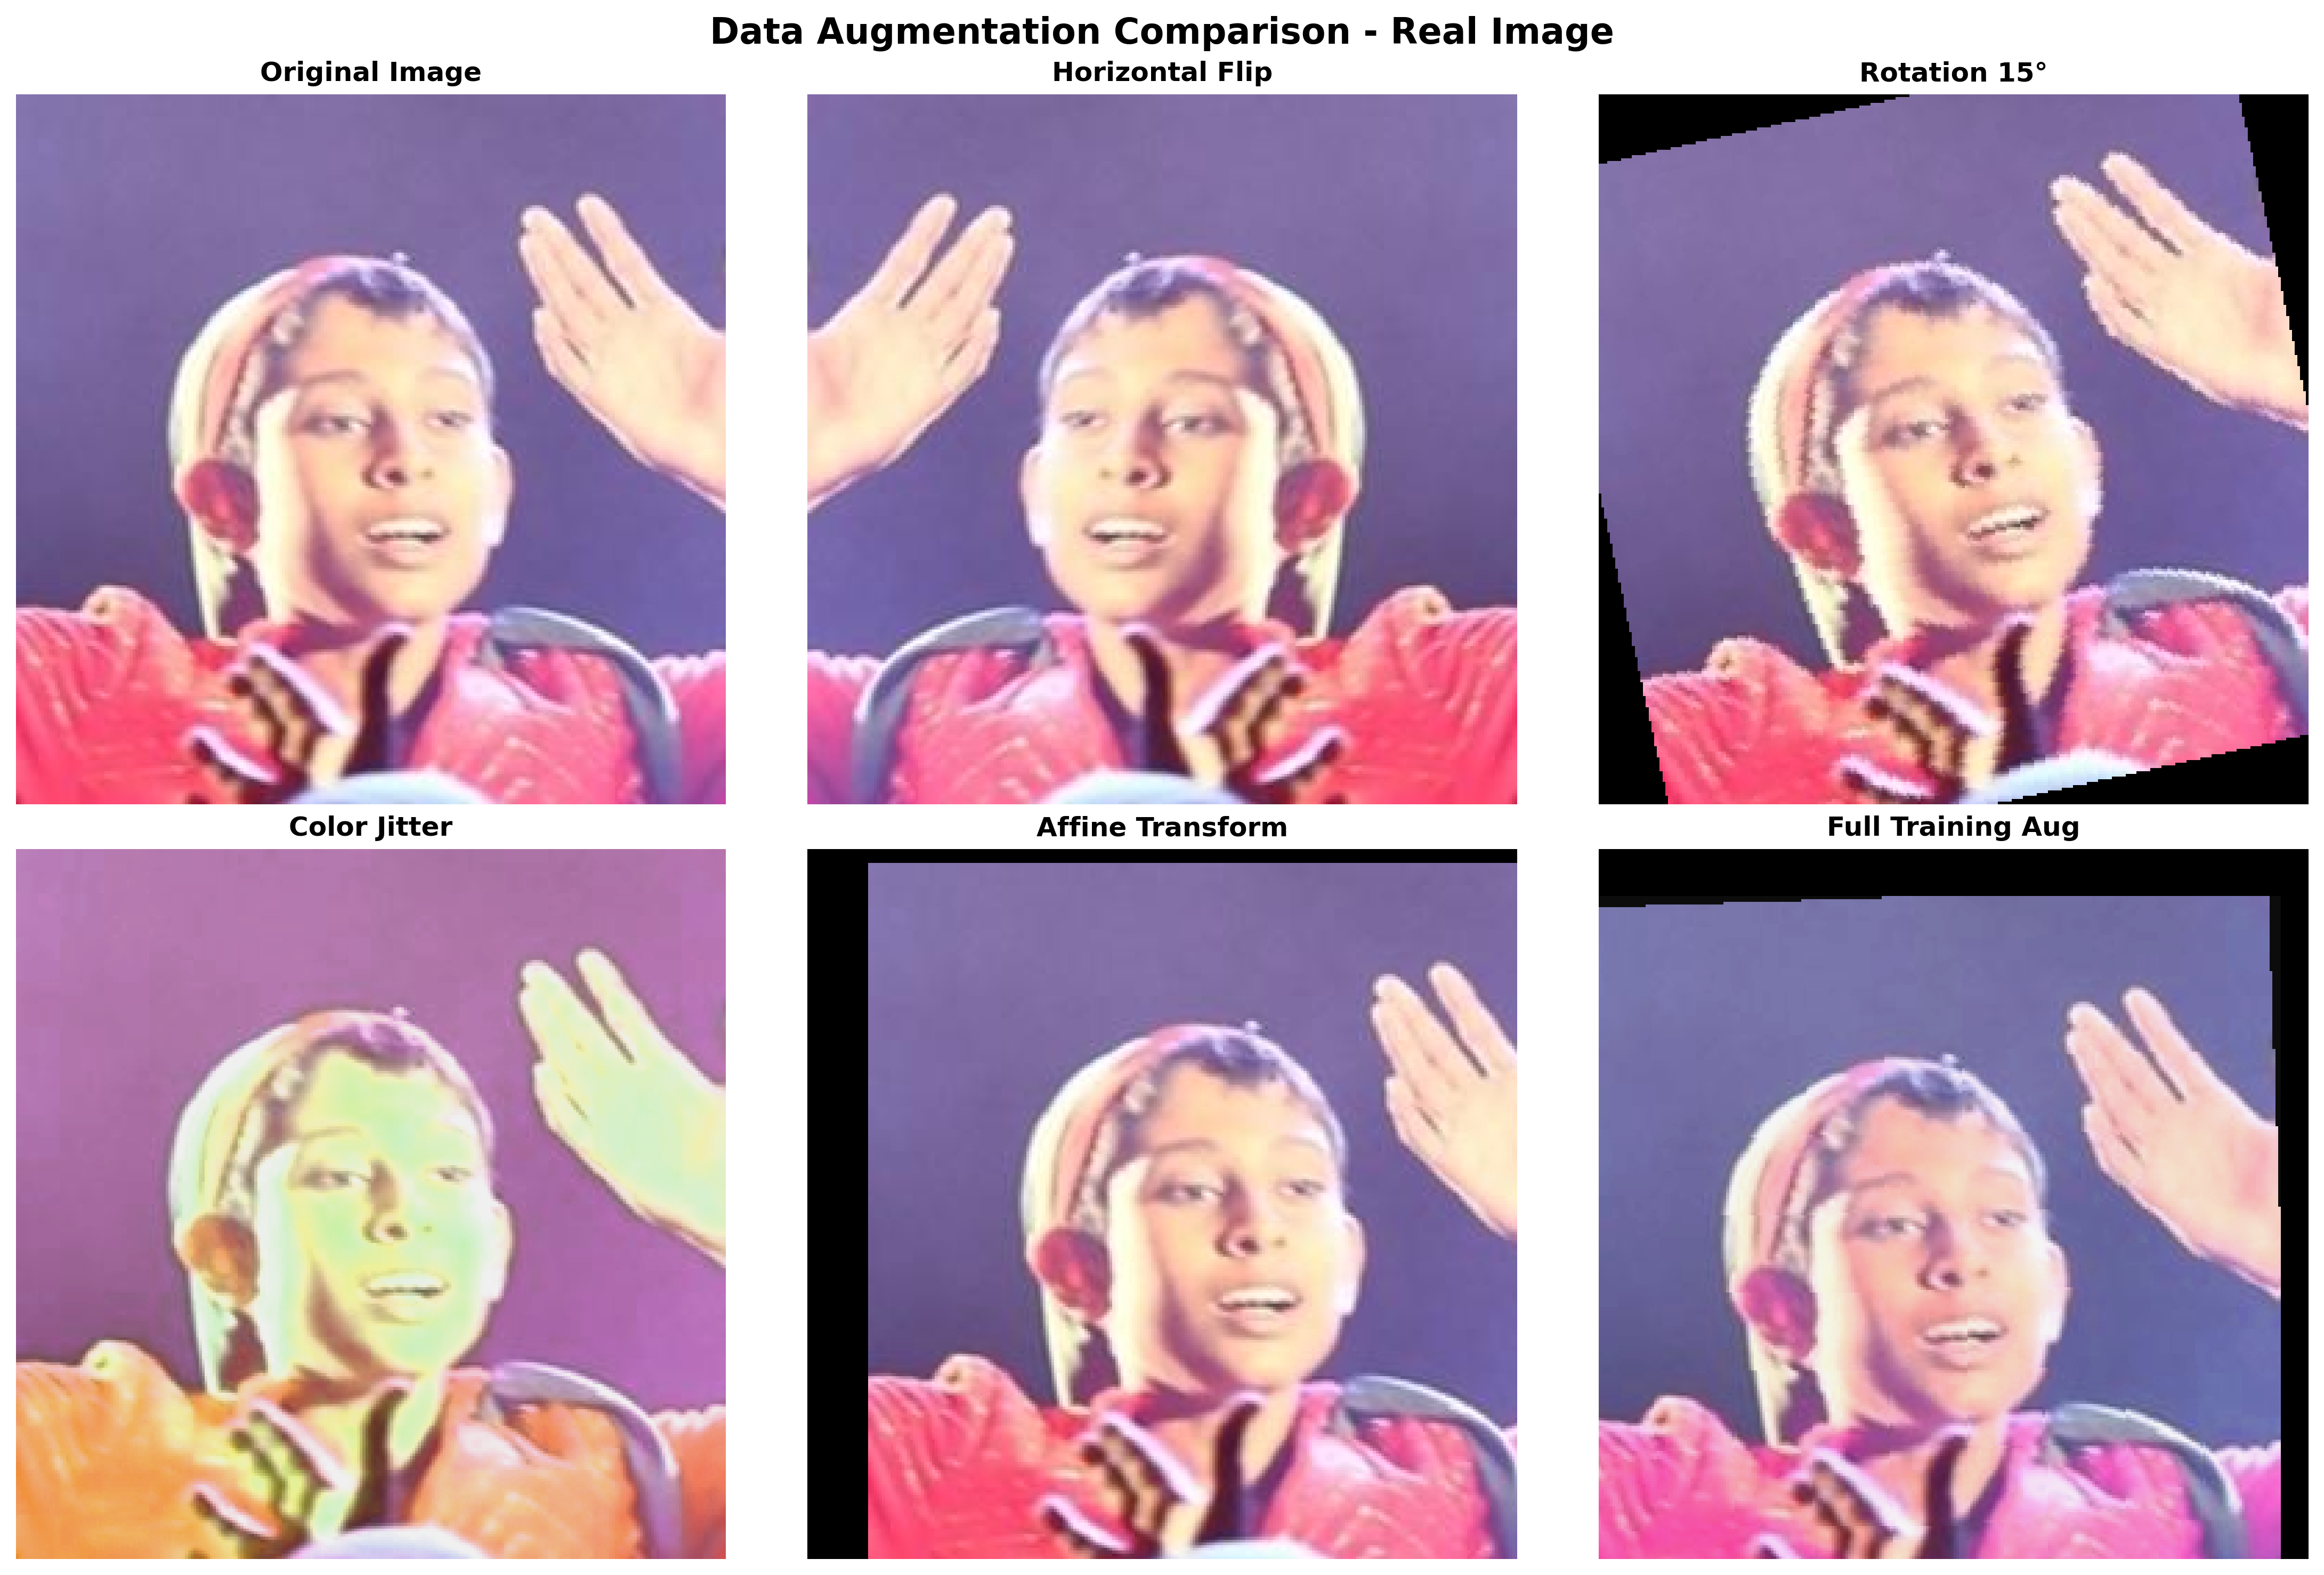

✅ Data augmentation comparison saved to: ./works/plots/data_augmentation_comparison.png


In [11]:
# Cell 10: 加载数据
print("📂 加载数据集...")
train_df = create_dataframe(TRAIN_PATH, "训练")
val_df = create_dataframe(VAL_PATH, "验证")

# 限制验证集大小为6400以减少内存使用
MAX_VAL_SAMPLES = 25600
if len(val_df) > MAX_VAL_SAMPLES:
    print(f"⚠️ 验证集过大 ({len(val_df)} 张)，随机采样 {MAX_VAL_SAMPLES} 张图片")
    # 保持类别平衡的随机采样
    val_df = val_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(len(x), MAX_VAL_SAMPLES//2), random_state=42)
    ).reset_index(drop=True)
    print(f"✅ 验证集采样完成，当前大小: {len(val_df)}")
    print(f"验证集类别分布:")
    for idx, cls in enumerate(classes):
        count = len(val_df[val_df['label'] == idx])
        print(f"  {cls}: {count} ({count/len(val_df)*100:.1f}%)")

print(f"\n📊 数据集总览:")
print(f"训练集总数: {len(train_df)}")
print(f"验证集总数: {len(val_df)}")
print(f"验证批次数: {len(val_df) // BATCH_SIZE + (1 if len(val_df) % BATCH_SIZE > 0 else 0)}")

# 创建数据集和数据加载器
train_dataset = DeepfakeDataset(train_df, transform=train_transform)
val_dataset = DeepfakeDataset(val_df, transform=val_transform)

# 使用动态配置的num_workers和pin_memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# 生成数据增强效果对比图
print("\n🔄 生成数据增强效果对比图...")
visualize_data_augmentation(train_df)

In [12]:
# Cell 11: 训练所有模型
print("\n🚀 开始训练多个模型...")

# 选择要训练的模型（可以根据需要调整）
selected_models = ['efficientnet_b0', 'resnet18', 'convnext_tiny']  # 减少模型数量以适应Kaggle环境
model_paths = {}
model_results = {}

for model_key in selected_models:
    save_path = os.path.join(MODELS_DIR, f"best_{model_key}_model.pth")
    model_paths[model_key] = save_path
    
    # 使用新的训练函数返回格式
    model_results[model_key] = train_single_model(
        model_key, train_loader, val_loader, save_path
    )
    
    print(f"✅ {MODEL_CONFIGS[model_key]['name']} 训练完成，最佳验证准确率: {model_results[model_key]['best_acc']:.4f}")
    
    # 清理GPU内存
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()


🚀 开始训练多个模型...

🔥 Starting Training EfficientNet-B0
⚡ Using AMP (Automatic Mixed Precision) for faster training


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 110MB/s] 


✅ Model configured for multi-GPU training with 2 GPUs


Epoch 1/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0943, Val Loss: 0.0747, Val Acc: 0.9705, Val F1: 0.9705, LR: 0.000100 GPU Mem: 0.12GB/2.75GB
✅ Best model saved, validation accuracy: 0.9705


Epoch 2/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0474, Val Loss: 0.0677, Val Acc: 0.9745, Val F1: 0.9745, LR: 0.000100 GPU Mem: 0.12GB/2.76GB
✅ Best model saved, validation accuracy: 0.9745


Epoch 3/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0391, Val Loss: 0.0613, Val Acc: 0.9775, Val F1: 0.9775, LR: 0.000100 GPU Mem: 0.12GB/2.76GB
✅ Best model saved, validation accuracy: 0.9775


Epoch 4/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0338, Val Loss: 0.0565, Val Acc: 0.9781, Val F1: 0.9781, LR: 0.000100 GPU Mem: 0.12GB/2.76GB
✅ Best model saved, validation accuracy: 0.9781


Epoch 5/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0315, Val Loss: 0.0591, Val Acc: 0.9805, Val F1: 0.9805, LR: 0.000100 GPU Mem: 0.12GB/2.76GB
✅ Best model saved, validation accuracy: 0.9805


Epoch 6/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0291, Val Loss: 0.0627, Val Acc: 0.9794, Val F1: 0.9794, LR: 0.000100 GPU Mem: 0.12GB/2.76GB


Epoch 7/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0272, Val Loss: 0.0522, Val Acc: 0.9817, Val F1: 0.9817, LR: 0.000100 GPU Mem: 0.12GB/2.76GB
✅ Best model saved, validation accuracy: 0.9817


Epoch 8/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0270, Val Loss: 0.0614, Val Acc: 0.9806, Val F1: 0.9806, LR: 0.000100 GPU Mem: 0.12GB/2.76GB


Epoch 9/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0252, Val Loss: 0.0592, Val Acc: 0.9823, Val F1: 0.9823, LR: 0.000100 GPU Mem: 0.12GB/2.76GB
✅ Best model saved, validation accuracy: 0.9823


Epoch 10/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0249, Val Loss: 0.0597, Val Acc: 0.9805, Val F1: 0.9805, LR: 0.000100 GPU Mem: 0.12GB/2.76GB


Epoch 11/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.0238, Val Loss: 0.0481, Val Acc: 0.9848, Val F1: 0.9848, LR: 0.000100 GPU Mem: 0.12GB/2.76GB
✅ Best model saved, validation accuracy: 0.9848


Epoch 12/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.0237, Val Loss: 0.0535, Val Acc: 0.9838, Val F1: 0.9838, LR: 0.000100 GPU Mem: 0.12GB/2.76GB


Epoch 13/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.0230, Val Loss: 0.0594, Val Acc: 0.9813, Val F1: 0.9813, LR: 0.000100 GPU Mem: 0.12GB/2.76GB


Epoch 14/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.0227, Val Loss: 0.0550, Val Acc: 0.9821, Val F1: 0.9821, LR: 0.000100 GPU Mem: 0.12GB/2.76GB


Epoch 15/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.0234, Val Loss: 0.0426, Val Acc: 0.9854, Val F1: 0.9854, LR: 0.000100 GPU Mem: 0.12GB/2.76GB
✅ Best model saved, validation accuracy: 0.9854
⏱️ Training completed in 12021.94 seconds
🧹 最终 GPU 显存占用: 0.12GB
✅ EfficientNet-B0 训练完成，最佳验证准确率: 0.9854

🔥 Starting Training ResNet18
⚡ Using AMP (Automatic Mixed Precision) for faster training


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 116MB/s]


✅ Model configured for multi-GPU training with 2 GPUs


Epoch 1/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0860, Val Loss: 0.0797, Val Acc: 0.9709, Val F1: 0.9709, LR: 0.000100 GPU Mem: 0.23GB/2.76GB
✅ Best model saved, validation accuracy: 0.9709


Epoch 2/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0510, Val Loss: 0.0765, Val Acc: 0.9702, Val F1: 0.9701, LR: 0.000100 GPU Mem: 0.23GB/2.76GB


Epoch 3/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0442, Val Loss: 0.0774, Val Acc: 0.9721, Val F1: 0.9721, LR: 0.000100 GPU Mem: 0.23GB/2.76GB
✅ Best model saved, validation accuracy: 0.9721


Epoch 4/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0400, Val Loss: 0.0894, Val Acc: 0.9677, Val F1: 0.9677, LR: 0.000100 GPU Mem: 0.23GB/2.76GB


Epoch 5/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0377, Val Loss: 0.0630, Val Acc: 0.9767, Val F1: 0.9767, LR: 0.000100 GPU Mem: 0.23GB/2.76GB
✅ Best model saved, validation accuracy: 0.9767


Epoch 6/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0358, Val Loss: 0.1065, Val Acc: 0.9652, Val F1: 0.9651, LR: 0.000100 GPU Mem: 0.23GB/2.76GB


Epoch 7/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0339, Val Loss: 0.0950, Val Acc: 0.9678, Val F1: 0.9678, LR: 0.000100 GPU Mem: 0.23GB/2.76GB


Epoch 8/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0325, Val Loss: 0.0511, Val Acc: 0.9833, Val F1: 0.9833, LR: 0.000100 GPU Mem: 0.23GB/2.76GB
✅ Best model saved, validation accuracy: 0.9833


Epoch 9/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0314, Val Loss: 0.0505, Val Acc: 0.9823, Val F1: 0.9823, LR: 0.000100 GPU Mem: 0.23GB/2.76GB


Epoch 10/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0306, Val Loss: 0.1450, Val Acc: 0.9503, Val F1: 0.9502, LR: 0.000100 GPU Mem: 0.23GB/2.76GB


Epoch 11/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.0293, Val Loss: 0.0709, Val Acc: 0.9750, Val F1: 0.9750, LR: 0.000100 GPU Mem: 0.23GB/2.76GB


Epoch 12/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.0287, Val Loss: 0.0853, Val Acc: 0.9732, Val F1: 0.9732, LR: 0.000100 GPU Mem: 0.23GB/2.76GB
⛔ Early stopping triggered
⏱️ Training completed in 8094.12 seconds
🧹 最终 GPU 显存占用: 0.23GB
✅ ResNet18 训练完成，最佳验证准确率: 0.9833

🔥 Starting Training ConvNeXt-Tiny
⚡ Using AMP (Automatic Mixed Precision) for faster training


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 180MB/s]


✅ Model configured for multi-GPU training with 2 GPUs


Epoch 1/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0720, Val Loss: 0.0573, Val Acc: 0.9791, Val F1: 0.9791, LR: 0.000100 GPU Mem: 0.48GB/4.05GB
✅ Best model saved, validation accuracy: 0.9791


Epoch 2/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0420, Val Loss: 0.0539, Val Acc: 0.9804, Val F1: 0.9804, LR: 0.000100 GPU Mem: 0.48GB/4.05GB
✅ Best model saved, validation accuracy: 0.9804


Epoch 3/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0381, Val Loss: 0.0551, Val Acc: 0.9808, Val F1: 0.9808, LR: 0.000100 GPU Mem: 0.48GB/4.05GB
✅ Best model saved, validation accuracy: 0.9808


Epoch 4/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0358, Val Loss: 0.1295, Val Acc: 0.9558, Val F1: 0.9557, LR: 0.000100 GPU Mem: 0.48GB/4.05GB


Epoch 5/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0346, Val Loss: 0.0544, Val Acc: 0.9823, Val F1: 0.9823, LR: 0.000100 GPU Mem: 0.48GB/4.05GB
✅ Best model saved, validation accuracy: 0.9823


Epoch 6/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0356, Val Loss: 0.0488, Val Acc: 0.9844, Val F1: 0.9844, LR: 0.000100 GPU Mem: 0.48GB/4.05GB
✅ Best model saved, validation accuracy: 0.9844


Epoch 7/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0332, Val Loss: 0.0610, Val Acc: 0.9780, Val F1: 0.9780, LR: 0.000100 GPU Mem: 0.48GB/4.05GB


Epoch 8/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0328, Val Loss: 0.0986, Val Acc: 0.9708, Val F1: 0.9708, LR: 0.000100 GPU Mem: 0.48GB/4.05GB


Epoch 9/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0327, Val Loss: 0.0947, Val Acc: 0.9736, Val F1: 0.9735, LR: 0.000100 GPU Mem: 0.48GB/4.05GB


Epoch 10/15 [Train]:   0%|          | 0/1459 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0308, Val Loss: 0.0648, Val Acc: 0.9787, Val F1: 0.9787, LR: 0.000050 GPU Mem: 0.48GB/4.05GB
⛔ Early stopping triggered
⏱️ Training completed in 7398.59 seconds
🧹 最终 GPU 显存占用: 0.48GB
✅ ConvNeXt-Tiny 训练完成，最佳验证准确率: 0.9844


In [13]:
# Cell 12: 增强训练历史可视化
print("\n📊 生成训练历史可视化...")
plot_training_history(model_results)


📊 生成训练历史可视化...
📊 Generating training history visualizations...
✅ Saved: ./works/plots/efficientnet_b0_training_history.png
✅ Saved: ./works/plots/resnet18_training_history.png
✅ Saved: ./works/plots/convnext_tiny_training_history.png
✅ Saved: ./works/plots/multi_model_comparison.png


In [14]:
# Cell 13: 集成预测和评估
print("\n🔮 开始集成预测...")

# 加载训练好的模型
trained_models = load_trained_models(model_paths)

# 计算模型权重
print("\n⚖️ 计算模型权重...")
model_weights = calculate_model_weights(model_results, weight_method='accuracy')
print("模型权重分配:")
for model_key, weight in model_weights.items():
    print(f"  {MODEL_CONFIGS[model_key]['name']:15}: {weight:.4f}")

# 软投票预测
print("\n📊 软投票集成预测:")
soft_predictions, true_labels, _ = ensemble_predict(trained_models, val_loader, voting_type='soft')
soft_accuracy = accuracy_score(true_labels, soft_predictions)
print(f"软投票准确率: {soft_accuracy:.4f}")

# 硬投票预测
print("\n📊 硬投票集成预测:")
hard_predictions, _, _ = ensemble_predict(trained_models, val_loader, voting_type='hard')
hard_accuracy = accuracy_score(true_labels, hard_predictions)
print(f"硬投票准确率: {hard_accuracy:.4f}")

# 加权投票预测
print("\n📊 加权投票集成预测:")
weighted_predictions, _, _ = ensemble_predict(trained_models, val_loader, voting_type='weighted', weights=model_weights)
weighted_accuracy = accuracy_score(true_labels, weighted_predictions)
print(f"加权投票准确率: {weighted_accuracy:.4f}")


🔮 开始集成预测...
📂 加载训练好的模型...
✅ 成功加载 EfficientNet-B0 从 ./works/models/best_efficientnet_b0_model.pth
✅ 成功加载 ResNet18 从 ./works/models/best_resnet18_model.pth
✅ 成功加载 ConvNeXt-Tiny 从 ./works/models/best_convnext_tiny_model.pth
📊 成功加载 3/3 个模型

⚖️ 计算模型权重...
模型权重分配:
  EfficientNet-B0: 0.3337
  ResNet18       : 0.3330
  ConvNeXt-Tiny  : 0.3333

📊 软投票集成预测:
🔮 开始集成预测 (投票方式: soft)
⚡ 使用AMP加速集成预测


集成预测:   0%|          | 0/267 [00:00<?, ?it/s]

软投票准确率: 0.9879

📊 硬投票集成预测:
🔮 开始集成预测 (投票方式: hard)
⚡ 使用AMP加速集成预测


集成预测:   0%|          | 0/267 [00:00<?, ?it/s]

硬投票准确率: 0.9876

📊 加权投票集成预测:
🔮 开始集成预测 (投票方式: weighted)
⚡ 使用AMP加速集成预测


集成预测:   0%|          | 0/267 [00:00<?, ?it/s]

加权投票准确率: 0.9879


In [15]:
# Cell 14: 结果对比和可视化
# 单模型结果对比
print("\n📈 模型性能对比:")
print("="*50)
for model_key in selected_models:
    best_acc = model_results[model_key]['best_acc']
    print(f"{MODEL_CONFIGS[model_key]['name']:15}: {best_acc:.4f}")

print(f"{'软投票集成':15}: {soft_accuracy:.4f}")
print(f"{'硬投票集成':15}: {hard_accuracy:.4f}")
print(f"{'加权投票集成':15}: {weighted_accuracy:.4f}")

# 增强混淆矩阵可视化
print("\n📊 生成混淆矩阵可视化...")
plot_confusion_matrix(true_labels, soft_predictions, "Soft Voting Ensemble", "soft_voting")
plot_confusion_matrix(true_labels, hard_predictions, "Hard Voting Ensemble", "hard_voting")
plot_confusion_matrix(true_labels, weighted_predictions, "Weighted Voting Ensemble", "weighted_voting")



📈 模型性能对比:
EfficientNet-B0: 0.9854
ResNet18       : 0.9833
ConvNeXt-Tiny  : 0.9844
软投票集成          : 0.9879
硬投票集成          : 0.9876
加权投票集成         : 0.9879

📊 生成混淆矩阵可视化...
✅ Saved: ./works/plots/soft_voting_confusion_matrix.png
✅ Saved: ./works/plots/hard_voting_confusion_matrix.png
✅ Saved: ./works/plots/weighted_voting_confusion_matrix.png


In [16]:
# Cell 15: 详细分类报告
print("\n📋 软投票详细分类报告:")
print("="*50)
print(classification_report(true_labels, soft_predictions, target_names=classes))

print("\n📋 硬投票详细分类报告:")
print("="*50)
print(classification_report(true_labels, hard_predictions, target_names=classes))

print("\n📋 加权投票详细分类报告:")
print("="*50)
print(classification_report(true_labels, weighted_predictions, target_names=classes))



📋 软投票详细分类报告:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99     12800
        Fake       0.99      0.99      0.99     12800

    accuracy                           0.99     25600
   macro avg       0.99      0.99      0.99     25600
weighted avg       0.99      0.99      0.99     25600


📋 硬投票详细分类报告:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99     12800
        Fake       0.99      0.99      0.99     12800

    accuracy                           0.99     25600
   macro avg       0.99      0.99      0.99     25600
weighted avg       0.99      0.99      0.99     25600


📋 加权投票详细分类报告:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99     12800
        Fake       0.99      0.99      0.99     12800

    accuracy                           0.99     25600
   macro avg       0.99      0.99      0.99     25600
weighted avg       0.99      0.

In [17]:
# Cell 16: 集成分析和解释性可视化
print("\n📊 生成集成分析可视化...")
plot_ensemble_analysis(trained_models, val_loader, DEVICE)

print("\n📊 生成模型解释性分析...")
plot_interpretability_analysis(trained_models, val_loader, DEVICE)


📊 生成集成分析可视化...
🔍 生成集成分析可视化...


收集模型预测:   0%|          | 0/267 [00:00<?, ?it/s]

📊 数据验证: 真实标签数量=25600
📊 EfficientNet-B0 预测数量=25600
📊 ResNet18 预测数量=25600
📊 ConvNeXt-Tiny 预测数量=25600
📊 EfficientNet-B0 准确率: 0.9854
📊 ResNet18 准确率: 0.9833
📊 ConvNeXt-Tiny 准确率: 0.9844
🔍 计算集成预测置信度...


计算置信度:   0%|          | 0/267 [00:00<?, ?it/s]

✅ 保存集成分析: ./works/plots/ensemble_analysis.png

📊 生成模型解释性分析...
🔍 生成模型解释性分析...
✅ 保存解释性分析: ./works/plots/interpretability_analysis_enhanced.png


In [18]:
# Cell 17: 最终总结
print("\n" + "="*60)
print("🎉 多模型集成训练完成！")
print("="*60)
print(f"训练的模型数量: {len(selected_models)}")
print(f"最佳单模型准确率: {max([results['best_acc'] for results in model_results.values()]):.4f}")
print(f"软投票集成准确率: {soft_accuracy:.4f}")
print(f"硬投票集成准确率: {hard_accuracy:.4f}")
print(f"加权投票集成准确率: {weighted_accuracy:.4f}")

# 计算提升幅度
best_single = max([results['best_acc'] for results in model_results.values()])
soft_improvement = (soft_accuracy - best_single) * 100
hard_improvement = (hard_accuracy - best_single) * 100
weighted_improvement = (weighted_accuracy - best_single) * 100

print(f"软投票相对提升: {soft_improvement:+.2f}%")
print(f"硬投票相对提升: {hard_improvement:+.2f}%")
print(f"加权投票相对提升: {weighted_improvement:+.2f}%")

# 找出最佳集成方法
ensemble_results = {
    '软投票': soft_accuracy,
    '硬投票': hard_accuracy,
    '加权投票': weighted_accuracy
}
best_ensemble = max(ensemble_results, key=ensemble_results.get)
print(f"\n🏆 最佳集成方法: {best_ensemble} (准确率: {ensemble_results[best_ensemble]:.4f})")

print(f"\n💾 保存的模型文件:")
for model_key, path in model_paths.items():
    print(f"  {MODEL_CONFIGS[model_key]['name']}: {path}")

print(f"\n⚖️ 模型权重分配:")
for model_key, weight in model_weights.items():
    print(f"  {MODEL_CONFIGS[model_key]['name']}: {weight:.4f}")


🎉 多模型集成训练完成！
训练的模型数量: 3
最佳单模型准确率: 0.9854
软投票集成准确率: 0.9879
硬投票集成准确率: 0.9876
加权投票集成准确率: 0.9879
软投票相对提升: +0.25%
硬投票相对提升: +0.22%
加权投票相对提升: +0.25%

🏆 最佳集成方法: 软投票 (准确率: 0.9879)

💾 保存的模型文件:
  EfficientNet-B0: ./works/models/best_efficientnet_b0_model.pth
  ResNet18: ./works/models/best_resnet18_model.pth
  ConvNeXt-Tiny: ./works/models/best_convnext_tiny_model.pth

⚖️ 模型权重分配:
  EfficientNet-B0: 0.3337
  ResNet18: 0.3330
  ConvNeXt-Tiny: 0.3333
